**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Proyecto:**

**Datos de la entrega:** Jueves 21 de noviembre 2024

---

**Estudiantes:**
- Andrey Arguedas Espinoza

## • Prerequisites

### - This version is implemented in Anaconda Navigator, if you want to to run it on Google Colab make sure to have the Pro version and mount the instance
### - You need at leat 25GB RAM to run this project
### - Add the dataset to the same path you have the notebook so it loads inmediately

## • Import required libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #Super important for these type of projects where plotting consumes a lot of resources
import random

import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, LSTM, TimeDistributed, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

### • Define global variables for the project

In [2]:
# Path to UCF-101 dataset (replace with your path)
dataset_path = './UCF101/UCF-101/'
video_file = 'BaseballPitch/v_BaseballPitch_g07_c01.avi'  # example video file

checkpoints_classification = 'checkpoints_classification'

#checkpoint filename to save
checkpoint_filename = 'detection_model{epoch:02d}.h5'
#checkpoint filename to load
checkpoint_filename_load = 'detection_model05.h5'

# Specify frame size (width, height) for resizing
frame_size = (60, 60)
frames_per_video = 64
batch_size = 16

### • Functions to show video frames

In [3]:
# Function to read video frames
def read_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frames.append(frame)
    cap.release()
    return frames

# Function to visualize video frames in a multi-row grid
def visualize_video(frames, num_frames=16, num_rows=2):
    num_cols = num_frames // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    
    for i in range(num_frames):
        row = i // num_cols
        col = i % num_cols
        if i < len(frames):
            axes[row, col].imshow(frames[i])
        axes[row, col].axis('off')
        
    plt.tight_layout()
    plt.show()

In [4]:
# Load and visualize video
#video_path = os.path.join(dataset_path, video_file)
#frames = read_video(video_path)
#visualize_video(frames, num_frames=64, num_rows=8)  # Display 64 frames

### • Load the UFC-101

In [5]:
def load_ucf101_category(category, frame_size=frame_size):
    """
    Load and resize videos from a specified category in the UCF-101 dataset.
    
    Args:
    - category (str): Name of the category folder (e.g., 'ApplyEyeMakeup')
    - frame_size (tuple): Desired frame size (width, height) for resizing
    
    Returns:
    - videos (dict): A dictionary with video filenames as keys and lists of frames as values.
    """
    category_path = os.path.join(dataset_path, category)
    videos = {}

    for video_file in os.listdir(category_path):
        if video_file.endswith('.avi'):
            video_path = os.path.join(category_path, video_file)
            cap = cv2.VideoCapture(video_path)
            frames = []

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                # Resize the frame
                frame = cv2.resize(frame, frame_size)
                # Convert BGR to RGB for consistency with other libraries
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            
            cap.release()
            videos[video_file] = frames  # Store frames by video filename
    
    return videos

In [6]:
# Example usage
category = 'Basketball'  # Replace with a category you want to load
#videos = load_ucf101_category(category, frame_size=frame_size)

# Checking one example video
#for video_name, frames in videos.items():
    #print(f"Loaded video '{video_name}' with {len(frames)} frames resized to {frame_size}.")
    #visualize_video(frames, num_frames=64, num_rows=8)  # Display 64 frames
    #break  # Just to print one example, remove if you want to list all

In [7]:
# Function to read video and resize frames
def load_video(video_path, frame_size=frame_size, num_frames=frames_per_video):
    cap = cv2.VideoCapture(video_path)
    frames = []
    try:
        while len(frames) < num_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, frame_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    finally:
        cap.release()

    # If video is shorter than num_frames, repeat last frame
    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames, dtype=np.uint8)

# Function to create dataset in NumPy array format
def create_ucf101_dataset(dataset_path, frame_size=frame_size, num_frames=frames_per_video, load_ratio=2):
    video_data = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        for video_file in os.listdir(class_dir):
            if video_file.endswith('.avi') and random.randint(0, load_ratio) == 1:
                video_path = os.path.join(class_dir, video_file)
                video_frames = load_video(video_path, frame_size, frames_per_video)
                video_data.append(video_frames)
                labels.append(label)
                if len(video_data) % 1000 == 0:
                    print("Amount of loaded videos", len(video_data))

    # Convert lists to NumPy arrays
    video_data = np.array(video_data, dtype=np.uint8)
    labels = np.array(labels, dtype=np.int32)

    return video_data, labels, len(video_data)

In [8]:
# Create the dataset
dataset, labels, amount_of_videos = create_ucf101_dataset(dataset_path, frame_size=frame_size, num_frames=frames_per_video, load_ratio = 2)

Amount of loaded videos 1000
Amount of loaded videos 2000
Amount of loaded videos 3000
Amount of loaded videos 4000


In [9]:
#print(dataset.shape)
#print(dataset[0])
print(labels.shape)
print(labels)

(4457,)
[  0   0   0 ... 100 100 100]


### • Choose a random video and plot it

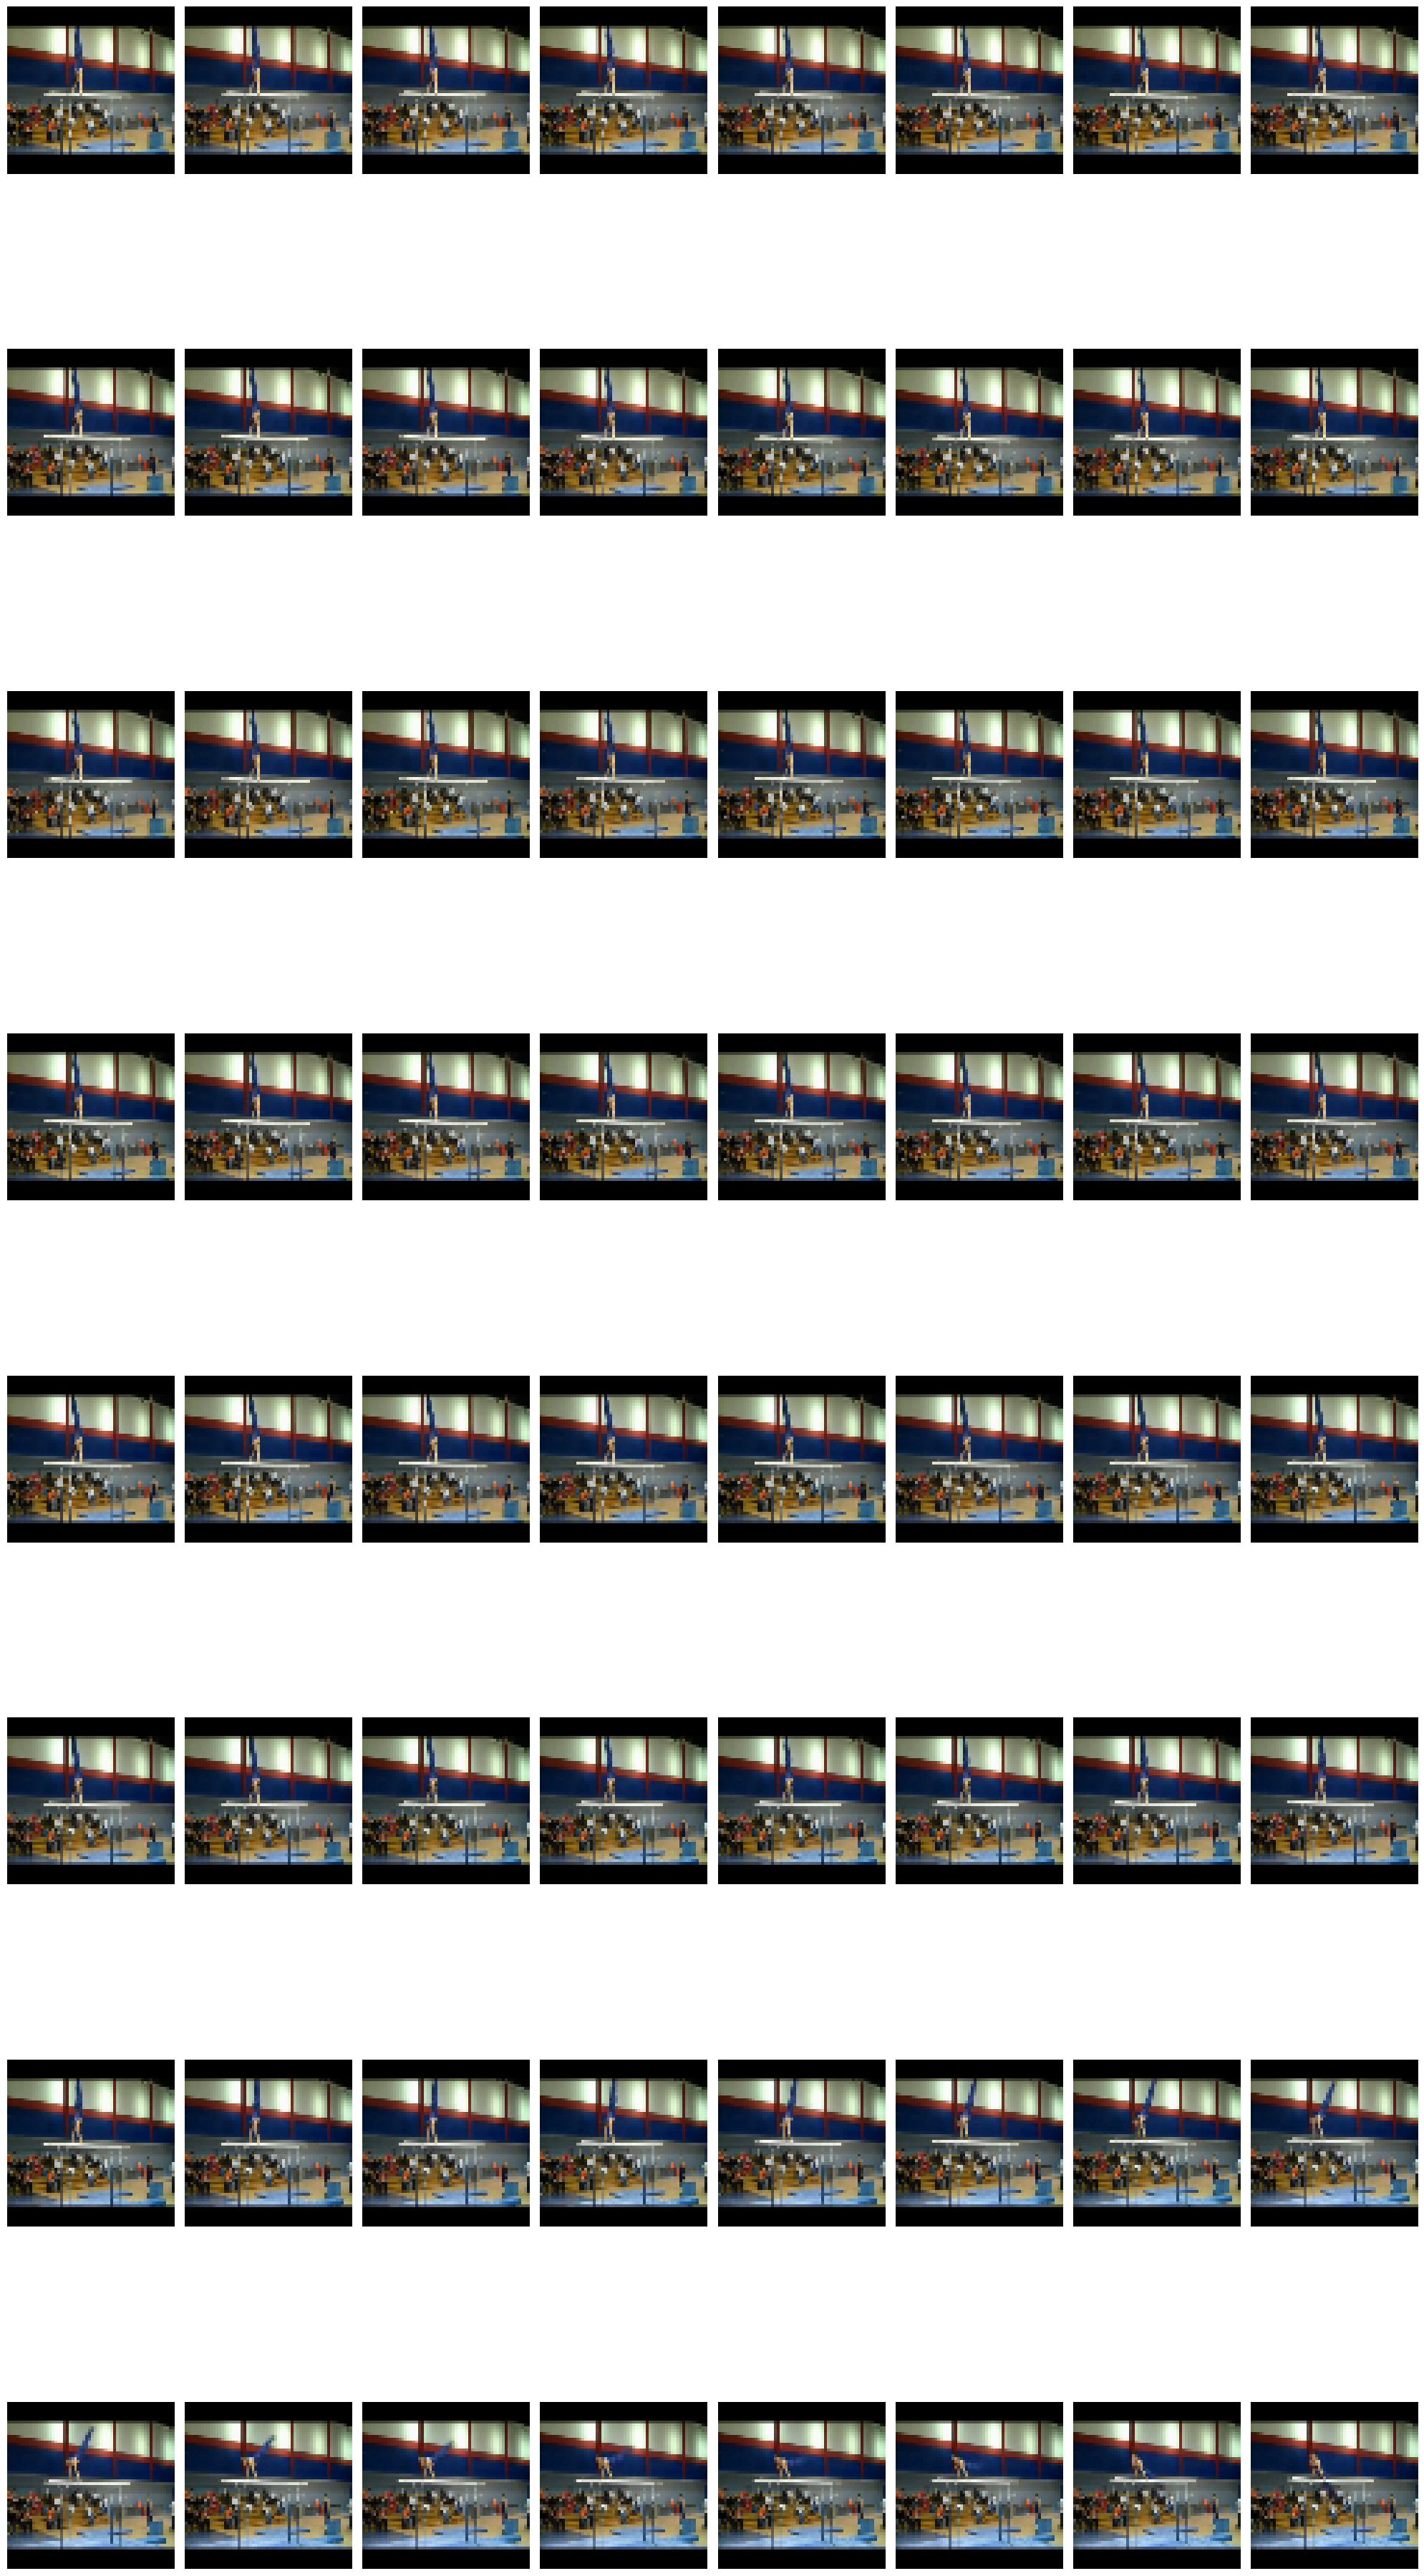

In [10]:
randomIndex = random.randint(0, dataset.shape[0])
visualize_video(dataset[randomIndex], num_frames=frames_per_video, num_rows=8)  # Display 64 frames

### • Dataset split

In [11]:
# Step 1: Split into train (70%) and remaining (30%)
X_train, X_remaining, y_train, y_remaining = train_test_split(dataset, labels, train_size=0.7)


# Step 2: Split remaining data into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5)

print("Dimensions of training data: ", X_train.shape)
print("Dimensions of training labels: ", y_train.shape)

print("Dimensions of validation data: ", X_val.shape)
print("Dimensions of validation labels: ", y_val.shape)

print("Dimensions of test data: ", X_test.shape)
print("Dimensions of test data: ", y_test.shape)


Dimensions of training data:  (3119, 64, 60, 60, 3)
Dimensions of training labels:  (3119,)
Dimensions of validation data:  (669, 64, 60, 60, 3)
Dimensions of validation labels:  (669,)
Dimensions of test data:  (669, 64, 60, 60, 3)
Dimensions of test data:  (669,)


### • Data normalization

In [12]:
X_train_normalized = X_train.astype('float32') / 255

X_val_normalized = X_val.astype('float32') / 255

X_test_normalized = X_test.astype('float32') / 255

#print("Example of frames transformation ", X_train_normalized[0])

#One Hot Encoding
y_train = to_categorical(y_train, num_classes=101)

y_val = to_categorical(y_val, num_classes=101)

y_test = to_categorical(y_test, num_classes=101)

print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


### Architectures

In [13]:
def build_action_detection_model(input_shape=(16, 60, 60, 3), num_classes=101):
    model = Sequential()

    # Reduced 3D CNN for spatio-temporal feature extraction
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten output and pass through LSTM
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(256, return_sequences=False))

    # Fully connected layers with fewer units
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [14]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_action_detection_classification_model_loaded_from_disk = False

if os.path.isfile(checkpoints_classification + '/'  + checkpoint_filename_load):
    print("Loading saved classification model!!!")
    action_detection_model = tf.keras.models.load_model(checkpoints_classification + '/'  + checkpoint_filename_load)
    was_action_detection_classification_model_loaded_from_disk = True
else:
    print("Creating classification model!!!")
    action_detection_model = build_action_detection_model(input_shape=(frames_per_video, 60, 60, 3))
    
action_detection_model.summary()

Loading saved classification model!!!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 62, 58, 58, 32)    2624      
                                                                 
 batch_normalization (BatchN  (None, 62, 58, 58, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 62, 29, 29, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 60, 27, 27, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 60, 27, 27, 64)   256       
 hNormalization)                                                 
                  

# *********************** Training phase *************************

### We use this common function to train all the architectures of our project, it also creates the checkpoints that we will save for each architecture

In [15]:
# Training the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=5, checkpoint_dir=''):
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision'])

    # Create checkpoints folder
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, checkpoint_filename),
        save_weights_only=False,  # Save the entire model, not just weights
        save_best_only=False,     # Save the model after every epoch, not just the best one
        monitor='loss',
        mode='min'
    )
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[checkpoint_cb])
    return history

In [16]:
def visualize_metrics(history, under_lim = -1, upper_lim = 1):
    pd.DataFrame(history.history).plot(figsize=(10, 7))
    plt.grid(True)
    plt.gca().set_ylim(under_lim, upper_lim)
    plt.xlabel("epochs")
    plt.show()

In [17]:
if was_action_detection_classification_model_loaded_from_disk is False:
    history = train_model(action_detection_model, X_train_normalized, y_train, X_val_normalized, y_val, batch_size=batch_size, epochs=5, checkpoint_dir=checkpoints_classification)
    visualize_metrics(history)

# *************************** Test phase ********************************

### • Here we will compare and test all the architectures

In [18]:
test_loss, test_acc, test_prec = action_detection_model.evaluate(X_test_normalized, y_test)
print('Test accuracy: ', test_acc)
print('Test Precision:', test_prec)
print('Test Loss:', test_loss)

21/21 [==============================] - 25s 1s/step - loss: 3.6930 - accuracy: 0.1330 - precision: 1.0000
Test accuracy:  0.1330343782901764
Test Precision: 1.0
Test Loss: 3.6930270195007324


In [19]:
# Evaluación del modelo
predicted = action_detection_model.predict(X_test_normalized)

print(predicted)

21/21 [==============================] - 26s 1s/step
[[0.04646669 0.02127506 0.01168831 ... 0.01579142 0.01195379 0.01839454]
 [0.024228   0.00546092 0.01646383 ... 0.00603129 0.01795796 0.00159794]
 [0.01321521 0.00502573 0.01381446 ... 0.01867345 0.01554004 0.00840651]
 ...
 [0.00838111 0.00969017 0.02378796 ... 0.00943647 0.01485529 0.01494396]
 [0.01982269 0.00823776 0.02546288 ... 0.0443304  0.01144384 0.03030965]
 [0.00295304 0.00135186 0.01542004 ... 0.00117718 0.01968855 0.00056567]]


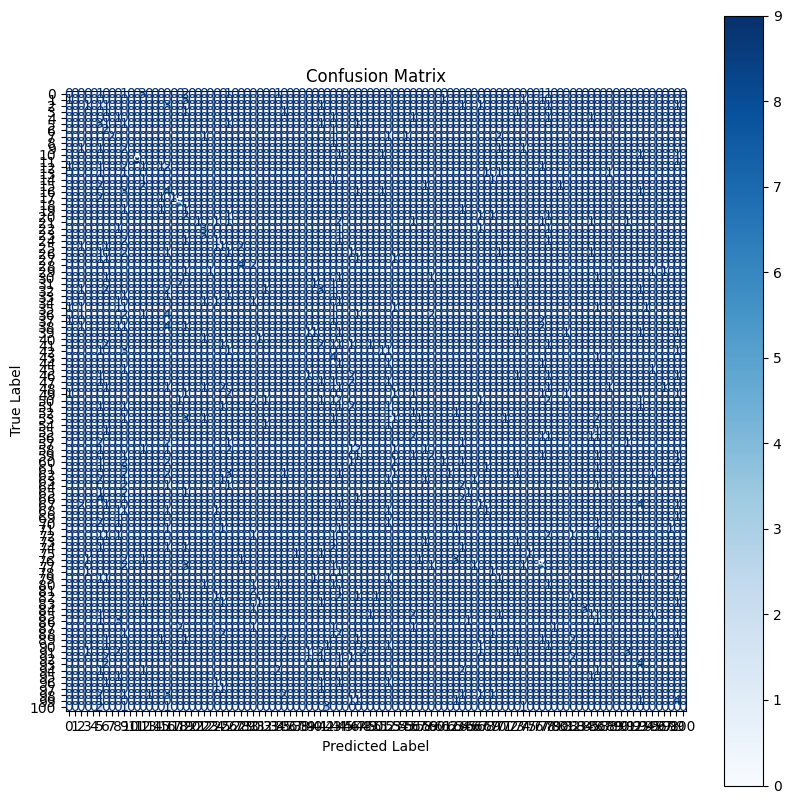

In [20]:
# Generate the confusion matrix
predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)



In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(80, 80))  # Set the figure size if needed
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()